In [68]:
# imports
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
parquet_file = '../nyc_energy_clean.parquet'

In [69]:
# literally just copied and pasted this from the data.py file.
# this makes a DB in memory, called buildings. it reads from the parquet file which is the FULL one, nyc_energy_clean.parquet
# also printed out the first 5 rows and all 21 columns we have
con = duckdb.connect(database=':memory:')
df = con.execute(f"""
SELECT *
FROM '{parquet_file}'
""").fetchdf()

print("Parquet file loaded into DuckDB as table 'buildings'.")
df.head()
print(df.dtypes)

Parquet file loaded into DuckDB as table 'buildings'.
Property ID                                                      int64
Property Name                                                   object
Address 1                                                       object
Postal Code                                                     object
Year Built                                                       int64
Primary Property Type - Portfolio Manager-Calculated            object
Latitude                                                       float64
Longitude                                                      float64
Borough                                                         object
Census Tract (2020)                                            float64
Neighborhood Tabulation Area (NTA) (2020)                       object
Property GFA - Calculated (Buildings) (ft²)                     object
Site Energy Use (kBtu)                                          object
Weather Normalized Site

In [70]:
# any of the 21 columns, that have values with a comma, say 1,200 or 57,123 or 52,941 pandas cannot treat it as a number
# so remove the commas to treat it like one. above i ran print(df.dtypes) and it shows that most of the columns are objects
# when they should be numbers bc it helps the visualization. cant really visualize objects

convert_objectcols_to_numbercols = [
    "Property GFA - Calculated (Buildings) (ft²)",
    "Site Energy Use (kBtu)",
    "Weather Normalized Site Energy Use (kBtu)",
    "Electricity Use - Grid Purchase (kWh)",
    "Natural Gas Use (therms)",
    "Site EUI (kBtu/ft²)",
    "Weather Normalized Site EUI (kBtu/ft²)",
    "ENERGY STAR Score",
    "Total (Location-Based) GHG Emissions (Metric Tons CO2e)",
    "Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)"
]

for col in convert_objectcols_to_numbercols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ""), errors="coerce")

df[convert_objectcols_to_numbercols].head()

,Property GFA - Calculated (Buildings) (ft²),Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Electricity Use - Grid Purchase (kWh),Natural Gas Use (therms),Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),ENERGY STAR Score,Total (Location-Based) GHG Emissions (Metric Tons CO2e),Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)
0,51749.0,520173.0,549073.9,20801.0,NaN,10.1,10.6,96.0,29.9,0.6
1,52941.0,3096670.2,3098143.2,481527.0,NaN,58.5,58.5,61.0,216.1,4.1
2,35196.0,2244816.6,2256449.1,408983.3,NaN,63.8,64.1,NaN,163.1,4.6
3,107234.0,7314028.3,7397823.5,642182.9,NaN,68.2,69.0,64.0,457.3,4.3
4,75191.0,3838751.8,3827725.2,1087688.0,NaN,51.1,50.9,98.0,320.9,4.3


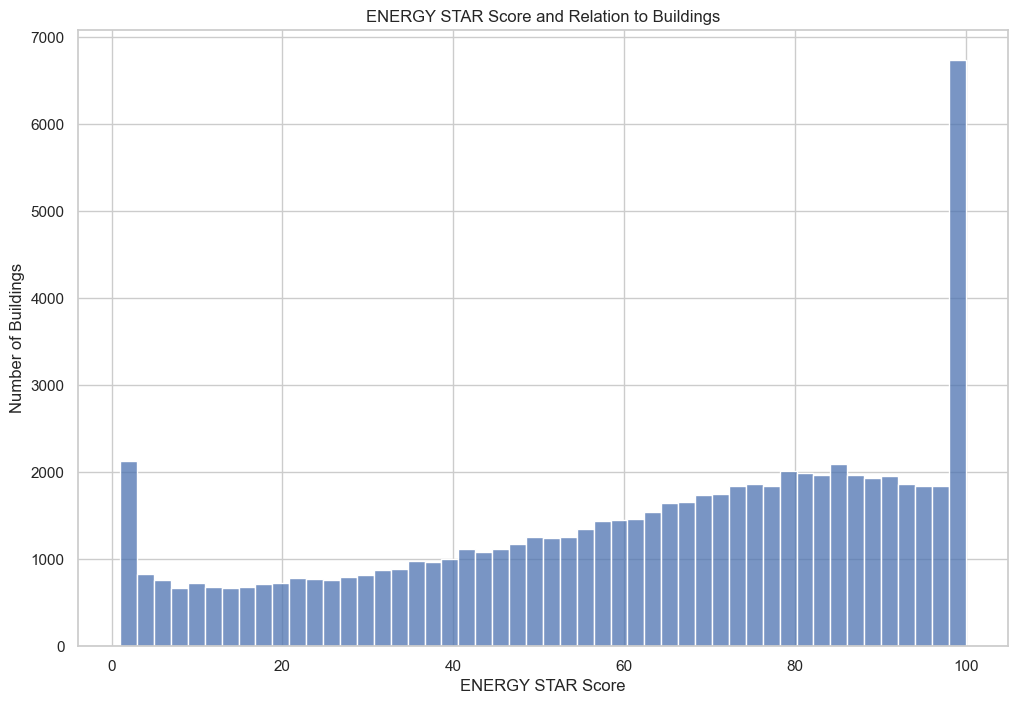

In [71]:
# the first and easiest plot to make is for the ENERGY STAR Score. According to NYC Open Data, this is a score from 1-100  and it represents 
# the worst performing buildings (1) to the best (100). "A score of 75 indicates that a property is performing in the 75th percentile and may be 
# eligible to earn ENERGY STAR Certification."
plt.figure(figsize=(12,8))
sns.histplot(df["ENERGY STAR Score"].dropna(), bins=50)
plt.title("ENERGY STAR Score and Relation to Buildings")
plt.xlabel("ENERGY STAR Score")
plt.ylabel("Number of Buildings")
plt.show()

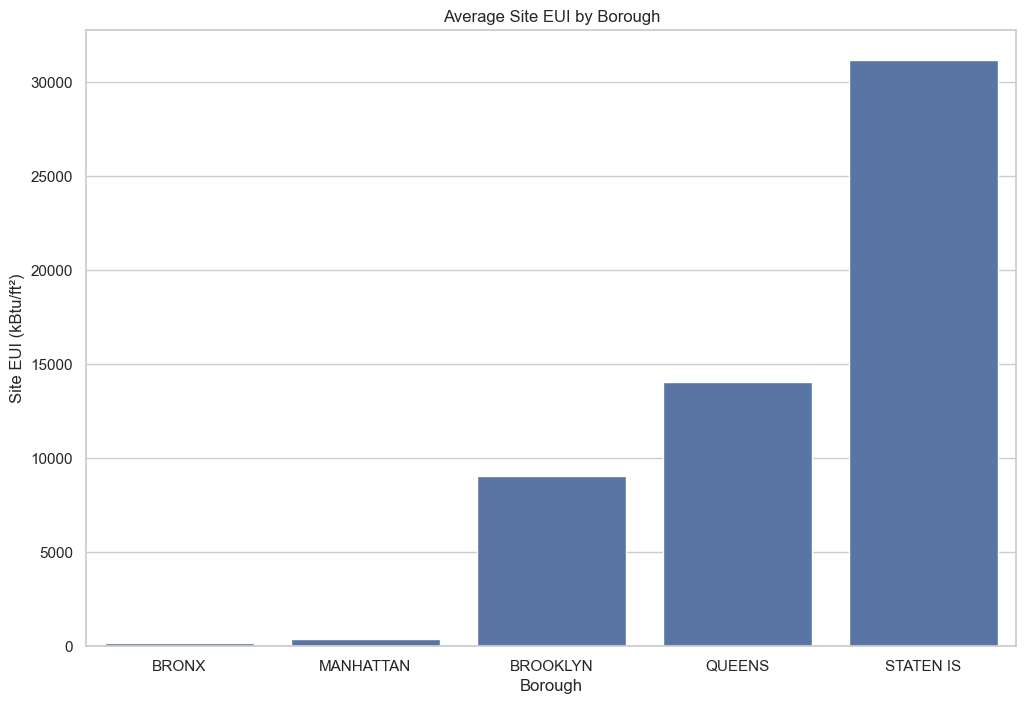

In [72]:
# next up is the Site Energy Use (kBtu). so according to the website, what this does is calculate the annual amount of all the energy your property 
# consumes on-site, regardless of the source. and I came up with this plot because it also says "Site Energy can be used to understand how the energy 
# use for an individual property has changed over time." so I did it for each borough and found the average.
borough_site_eui = df.groupby("Borough")["Site EUI (kBtu/ft²)"].mean().sort_values()
plt.figure(figsize=(12,8))
sns.barplot(x=borough_site_eui.index, y=borough_site_eui.values)
plt.title("Average Site EUI by Borough")
plt.ylabel("Site EUI (kBtu/ft²)")
plt.xlabel("Borough")
plt.show()

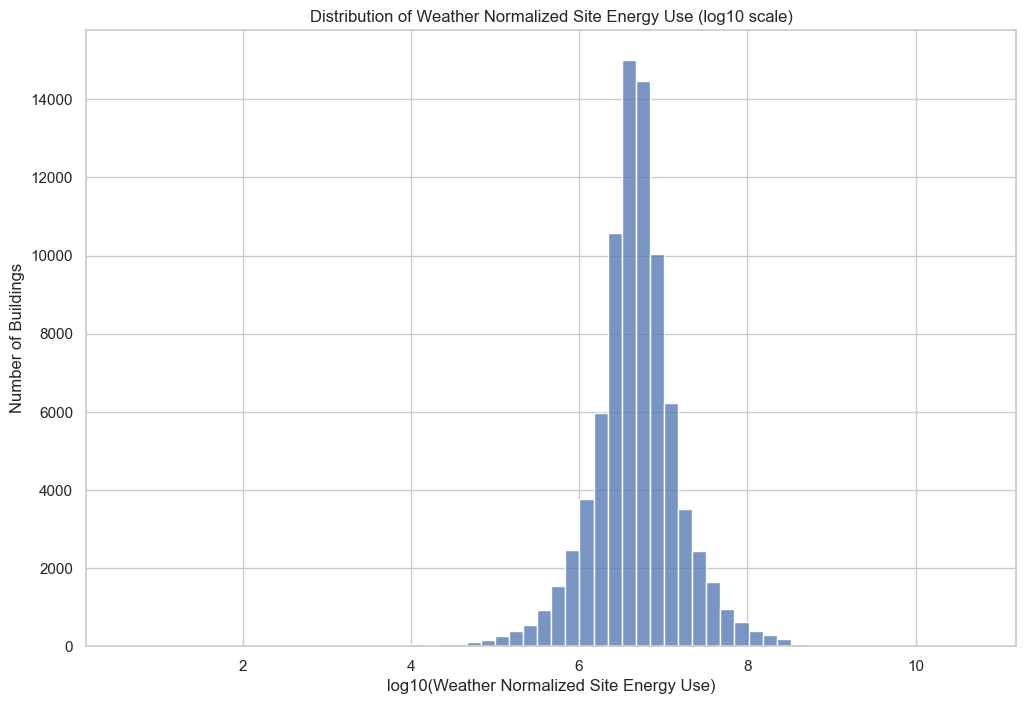

In [73]:
# this is an ai generated cell, i didnt know how to make the drawing for this because there were too many negative values here. and that made the
# original plot of mine to be wrong.
col = "Weather Normalized Site Energy Use (kBtu)"
df_filtered = df[df[col] > 0]

plt.figure(figsize=(12,8))
sns.histplot(np.log10(df_filtered[col]), bins=60)
plt.title("Distribution of Weather Normalized Site Energy Use (log10 scale)")
plt.xlabel("log10(Weather Normalized Site Energy Use)")
plt.ylabel("Number of Buildings")
plt.show()

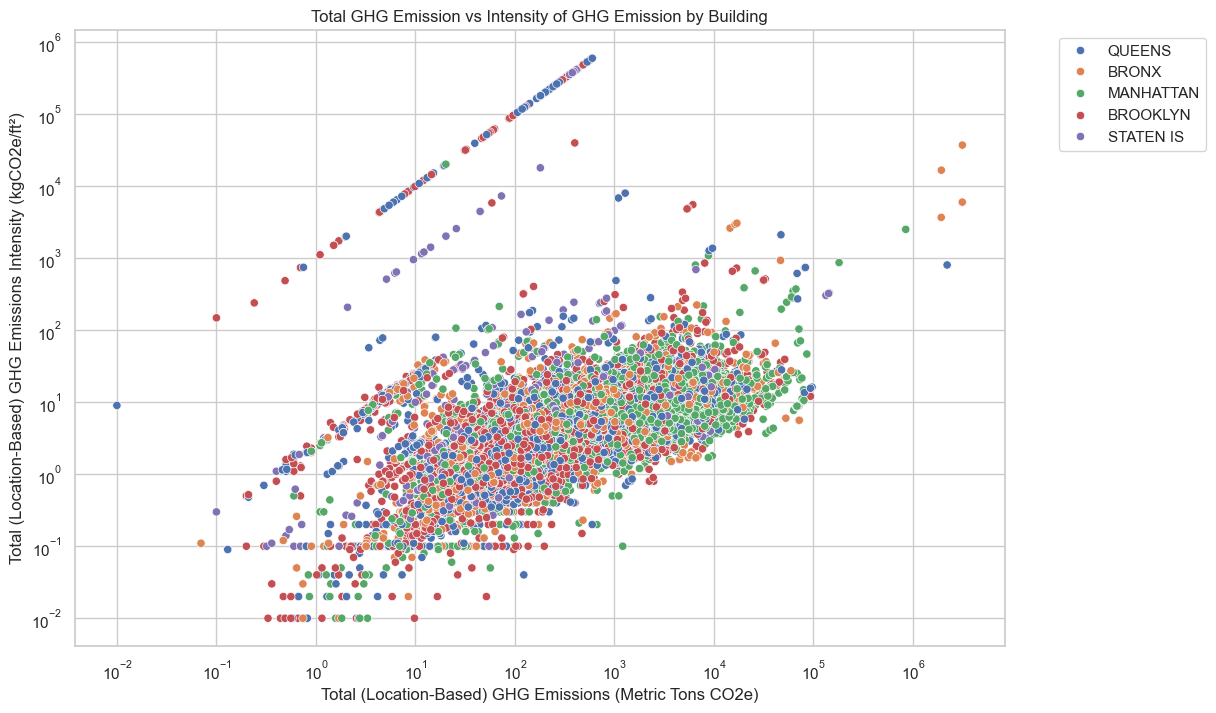

In [74]:
# now one thing i noticed in the 21 columns is that there are two that are basically identical, it's Total (Location-Based) GHG Emissions 
# (Metric Tons CO2e) and Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²). and i figured why not compare values. and the best way
# is a scatterplot. i did have to clean the data and log it bc a lot of values were in the negatives. 
# this scatter plot compares each buildings total GHG emissions with its emissions intensity per square foot.

df_clean = df[
    (df["Total (Location-Based) GHG Emissions (Metric Tons CO2e)"] > 0) &
    (df["Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)"] > 0)
]
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=df_clean,
    x="Total (Location-Based) GHG Emissions (Metric Tons CO2e)",
    y="Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)",
    hue="Borough",
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Total (Location-Based) GHG Emissions (Metric Tons CO2e)")
plt.ylabel("Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)")
plt.title("Total GHG Emission vs Intensity of GHG Emission by Building")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()